In [182]:
import numpy as np
import torch
import random

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Read Pages

In [183]:
with open('cains_jawbone.txt') as f:
    lines = f.readlines()
lines[0] = lines[0][1:]  # Remove special character at he beginning of the file

pages = {}

i = 1
for line in lines:
    if line == '________________\n':
        i += 1
    elif line == '\n':
        pass
    else:
        pages[i] = pages.get(i, '') + line

In [184]:
pages[2]

'I plunged for the last time. The few remaining figures and letters swam as they came up to me. Then I took them in. There were no more. I glanced about me. I felt I was getting my money’s worth. London is like that ; it accepts the wanderer home with a sort of warm indifference. The woman’s beauty was, I surmised, profound ; her creamy dress, contrasting with her vivid colouring, showed to me, though more as white against a gay brick sepulchre than snow against roses. Yes it was a dreadful beauty, as far as I could see, and I recalled the stark phrases : Which swept an hundred thousand souls away ; yet I alive. But he was not ; the writer had strangely died to-day. And again they continued this wretched course three or four days : but they were every one of them carried into the great pit before it was quite filled up. Where was Henry? Ah, he was standing by her, close enough to touch the small buoyant face that topped her pillared neck most like a bell-flower on its bed. Would he app

# Preprocessing

In [185]:
sentences = {}

for i, page in pages.items():
    sentences[i] = [s.strip(' \n').replace('\n        ', ' ') for s in page.split('.') if s != '\n' and s != '']
    sentences[i] = [sentence for sentence in sentences[i] if sentence != '']

In [186]:
sentences[12]

['I rubbed my eyes and massaged my temples with pronated finger-tips',
 'Then I fumbled two aspirin tablets into my mouth : Noel Coward’s King Charles’s Head',
 'I had a very bad head',
 'My vis-à-vis hadn’t a bad head, now I came to consider it, bowed over the documents',
 'It is a very ungentlemanly thing to read a private cigarette case',
 'I became a trifle abstracted',
 'What, I wondered, would he have said about an abstracted will? He might answer to the same name as the man who sang : “Ah, are you digging on my grave?” But a softer fellow I had rarely seen',
 'On velvet, yes, on velvet I would have trusted him ; but not on cinders, by no means on cinders',
 'Yet the keen eyes bent like small topaz searchlights over the writing',
 'I would get, I felt, what I wanted from this man',
 'But then I suddenly remembered the words of the poet : The golden one is gone from the banquets, She, beloved of Atimetus,']

In [187]:
sentences[100]

['I dimly guess why the old dead so wanted this',
 'I had worked for him, Henry had worked for him',
 'If I could get up, as, believe me, I cannot, I would have a thing to say to her',
 'She lolls over at me gloating, her mouth blood-tinted on the puma freckle of her beauty',
 'Why should I think of Henry at this particular juncture? I have it',
 'Scotland Yard, of course',
 'And little ‘twill matter to one',
 'A sorry thing to be last noticed : the buttonhole has escaped from the buttonholer',
 'He, the reckless old cock, slips down past Woolworth’s and she continues full-sail toward the Kursal, as flush---oh, you wicked woman---as May',
 'The girl is smiling at me',
 'That’s not so good',
 'Here I shake off the bur o’ the world, man’s congregation shun',
 'O beastly woman',
 'You know not how ill’s all here, about my heart ; but I know',
 'Henry, I feel it, is for the first and last time getting out of hand',
 'Good-bye, Henry',
 'He drops awa']

# Embeddings

Doc: https://huggingface.co/sentence-transformers


List of models: https://huggingface.co/models?library=sentence-transformers&language=en&sort=downloads



In [188]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [189]:
page_number = 1
sentence_number = 2

embedding = model.encode(sentences[page_number][sentence_number])

In [190]:
embedding.shape

(384,)

In [191]:
embeddings = {}

for page_number, sentence_list in sentences.items():
    embeddings[page_number] = [
        model.encode(sentence) for sentence in sentence_list
    ]

# Embeddings Pair Dataset

In [192]:
import numpy as np
from torch.utils.data import Dataset
from itertools import accumulate

class EmbeddingsPairDataset(Dataset):
    def __init__(self, embeddings: dict) -> None:
        super().__init__()
        self.embeddings = embeddings

        # For each sentence we provide one positive and one negative example except for the last one
        counts = [(len(page) - 1) for page in self.embeddings.values()]
        self.accum_counts = list(accumulate(counts))
        self.accum_counts.append(self.accum_counts[-1] + 1)
        self.len_ = 2 * sum(counts)

    def __len__(self) -> int:
        return self.len_

    def __getitem__(self, index) -> np.array:
        page_number, sentence_index = self.get_tuple_index(index=index // 2)

        embed = self.embeddings[page_number][sentence_index]

        if index < self.len_ // 2:
            other_embed = self.get_next_sentence_embed(page_number, sentence_index)
            label = 1.
        else:
            other_embed = self.get_not_next_sentence_embed(page_number, sentence_index)
            label = 0.
        
        return np.concatenate([embed, other_embed]), np.array(label, dtype=np.float32)

    def get_next_sentence_embed(self, page_number, sentence_index):
        return self.embeddings[page_number][sentence_index + 1]

    def get_not_next_sentence_embed(self, page_number, sentence_index):
        all_indices = list(range(len(self.embeddings[page_number])))
        all_indices.remove(sentence_index)
        all_indices.remove(sentence_index + 1)
        other_index = np.random.choice(all_indices, 1)[0]

        return self.embeddings[page_number][other_index]

    def get_tuple_index(self, index):
        for i, count in enumerate(self.accum_counts):
            if index < count:
                page_number = i + 1
                break
        
        sentence_index = index
        if i > 0:
            sentence_index -= self.accum_counts[i-1]

        return page_number, sentence_index


emb_pair_ds = EmbeddingsPairDataset(embeddings)
print(f'Number of samples in the dataset: {len(emb_pair_ds)}')

print(f'Number of sentences in page 1: {len(embeddings[1]) - 1}')
print(f'Number of sentences in page 2: {len(embeddings[2]) - 1}')
print(emb_pair_ds.get_tuple_index(index=0))
print(emb_pair_ds.get_tuple_index(index=13))
print(emb_pair_ds.get_tuple_index(index=14))
print(emb_pair_ds.get_tuple_index(index=25))
print(emb_pair_ds.get_tuple_index(index=26))

Number of samples in the dataset: 2074
Number of sentences in page 1: 14
Number of sentences in page 2: 12
(1, 0)
(1, 13)
(2, 0)
(2, 11)
(3, 0)


# MLP

In [193]:
import torch.nn as nn

layer_sizes = [768, 256, 64, 1]

model = nn.Sequential(
    nn.Linear(
        in_features=layer_sizes[0],
        out_features=layer_sizes[1],
    ),
    nn.ReLU(),
    nn.Linear(
        in_features=layer_sizes[1],
        out_features=layer_sizes[2],
    ),
    nn.ReLU(),
    nn.Linear(
        in_features=layer_sizes[2],
        out_features=layer_sizes[3],
    ),
    nn.Sigmoid(),
)

# Training

In [194]:
from torch.utils.data import DataLoader
from torch.optim import Adam

In [195]:
n_epochs = 5
batch_size = 32
optim = Adam(params=model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

dataloader = DataLoader(
    dataset=emb_pair_ds,
    batch_size=batch_size,
    shuffle=True,
)

losses = []

for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1} / {n_epochs}')
    for sentences, labels in dataloader:
        optim.zero_grad()

        preds = model(sentences)
        loss = loss_fn(preds.flatten(), labels)

        loss.backward()
        optim.step()
        losses.append(loss.item())

Epoch 1 / 5
Epoch 2 / 5
Epoch 3 / 5
Epoch 4 / 5
Epoch 5 / 5


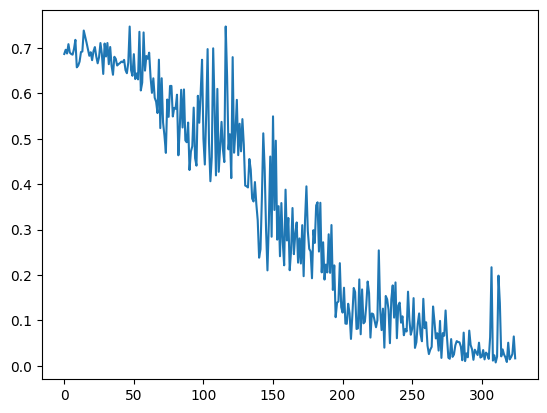

In [196]:
import matplotlib.pyplot as plt
plt.plot(losses)                                                                                                                                                                                                                                                                                                                                                                                

In [197]:
min(losses)

0.007600131444633007

# Inference

In [198]:
probabilities = {}
model.eval()

for page_number_a, sentences_a in embeddings.items():
    probs = {}

    for page_number_b, sentences_b in embeddings.items():
        if page_number_a == page_number_b:
            continue
        
        t = torch.tensor(
            np.concatenate(
                [sentences_a[-1], sentences_b[0]]
            )
        )
        probs[page_number_b] = model(t).item()
    
    probabilities[page_number_a] = probs



In [214]:
probabilities

{1: {2: 3.200041828677058e-05,
  3: 0.7117143273353577,
  4: 0.0524110309779644,
  5: 0.000783610506914556,
  6: 9.486657654633746e-05,
  7: 0.006014510057866573,
  8: 0.0017194082029163837,
  9: 0.213277667760849,
  10: 0.4075099527835846,
  11: 0.026535101234912872,
  12: 0.0015498925931751728,
  13: 0.9935302138328552,
  14: 0.932176947593689,
  15: 0.5328654646873474,
  16: 0.8910359740257263,
  17: 0.4985947906970978,
  18: 0.0002687140950001776,
  19: 0.9603848457336426,
  20: 0.021183036267757416,
  21: 0.0026358424220234156,
  22: 0.8023785948753357,
  23: 0.9911052584648132,
  24: 0.16103670001029968,
  25: 0.15965035557746887,
  26: 0.007372107356786728,
  27: 0.04942746460437775,
  28: 0.6348077654838562,
  29: 0.020157460123300552,
  30: 0.7755182981491089,
  31: 0.18759629130363464,
  32: 0.01426312979310751,
  33: 0.9992163181304932,
  34: 0.471611887216568,
  35: 0.010924058966338634,
  36: 0.03474227711558342,
  37: 0.038576528429985046,
  38: 0.0005339531344361603,
  3

<BarContainer object of 99 artists>

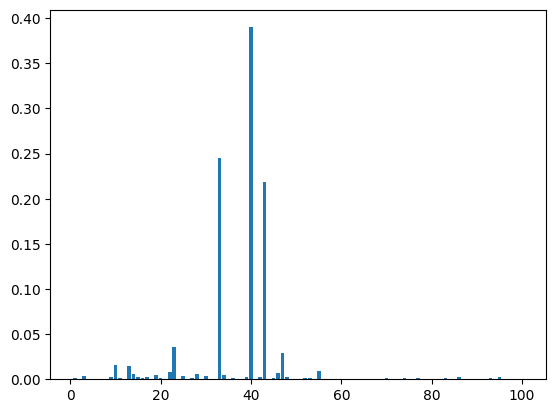

In [266]:
page_a = 60
plt.bar(probabilities[page_a].keys(), probabilities[page_a].values())

In [247]:
# from itertools import permutations
# import pandas as pd

# sequences = {
#     'sequence': [],
#     'probability': [],
# }

# for i, sequence in enumerate(permutations(list(range(1, 101)))):
#     if i % 1000 == 0:
#         print(i)
#     sequence_prob = 1

#     for page_number_a, page_number_b in zip(sequence, sequence[1:]):
#         sequence_prob *= probabilities[page_number_a][page_number_b]

#     sequences['sequence'].append(str(sequence))
#     sequences['probability'].append(sequence_prob)

# sequences = pd.DataFrame(sequences).sort_values(by='probability', ascending=False, ignore_index=True)

In [261]:
start_page = 60
all_pages = list(range(1, 101))
all_pages.remove(start_page)

greedy_order = [start_page]
greedy_probability = 1


while len(all_pages) > 0:
    sorted_probs = sorted(probabilities[greedy_order[-1]].items(), key=lambda x: -x[1])
    i = 0
    while sorted_probs[i][0] in greedy_order:
        i += 1

    next_page = sorted_probs[i][0]
    greedy_probability *= probabilities[greedy_order[-1]][next_page]
    greedy_order.append(next_page)
    all_pages.remove(next_page)

In [262]:
str(greedy_order)

'[60, 40, 33, 19, 13, 22, 47, 46, 43, 70, 34, 15, 11, 48, 23, 93, 14, 16, 31, 28, 30, 83, 3, 55, 20, 45, 1, 77, 42, 21, 39, 97, 25, 95, 10, 52, 99, 74, 17, 66, 27, 86, 85, 53, 36, 72, 100, 9, 24, 51, 62, 59, 63, 67, 75, 57, 29, 4, 41, 35, 37, 56, 89, 71, 68, 92, 65, 26, 44, 78, 84, 61, 98, 32, 94, 91, 96, 82, 76, 64, 69, 7, 79, 90, 81, 73, 12, 5, 80, 58, 54, 38, 8, 18, 50, 49, 87, 2, 6, 88]'